To begin copy this notebook to your own drive:

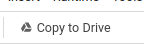


### Submission Instructions:
1. **Restart the kernel** (in the menubar, select Runtime$\rightarrow$Restart runtime)
2. **Download the notebook** (in the menubar, select File$\rightarrow$Download .ipynb)
3. **Upload the downloaded notebook (.ipynb file) to your repository**.


Make sure you fill in any place that says `YOUR CODE HERE`, and that no tests fail.  

Note: To use a GPU, do the following: Runtime$\rightarrow$Change runtime type$\rightarrow$ GPU

In [1]:
import gdown
import nltk
gdown.download('https://drive.google.com/uc?export=download&id=1PFOG06NEsTL6VieKQjMk1oNzyzcUtiWn', 'glove.npy', quiet=False)
gdown.download('https://drive.google.com/uc?export=download&id=1-3SxpirQjmX-RCRyRjKdP2L7G_tNgp00', 'vocab.json', quiet=False)

nltk.download('punkt')

Downloading...
From: https://drive.google.com/uc?export=download&id=1PFOG06NEsTL6VieKQjMk1oNzyzcUtiWn
To: /content/glove.npy
100%|██████████| 480M/480M [00:12<00:00, 37.8MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1-3SxpirQjmX-RCRyRjKdP2L7G_tNgp00
To: /content/vocab.json
100%|██████████| 7.69M/7.69M [00:00<00:00, 33.3MB/s]
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
!pip install datasets
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 70.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 21.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 79.7 MB/s eta 0:00

In [4]:
import numpy as np
from datasets import load_dataset


raw_datasets = load_dataset("imdb")


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
pip install --upgrade accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 6.3 MB/s eta 0:00:00


In [5]:

from nltk.tokenize import word_tokenize
import json

with open("vocab.json") as f:
  vocab = json.load(f)

def tokenize_function(example):
  sentences = [x.lower() for x in example['text']]
  tokenized_sentences = [word_tokenize(x) for x in sentences]
  tokenized_idx = [[vocab[word] if word in vocab else vocab["unk"] for word in x] for x in tokenized_sentences]
  max_size = max([len(x) for x in tokenized_idx])
  final_tokenized_idx = tokenized_idx

  return {"labels":example['label'],'input_ids':final_tokenized_idx}

In [6]:
small_train_dataset = raw_datasets['train'].shuffle(seed=42).map(tokenize_function,batched=True)
small_eval_dataset = raw_datasets['test'].shuffle(seed=42).map(tokenize_function,batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [7]:
def pad_sequence_to_length(
    sequence,
    desired_length: int,
    default_value = lambda: 0,
    padding_on_right: bool = True,
):
    sequence = list(sequence)
    # Truncates the sequence to the desired length.
    if padding_on_right:
        padded_sequence = sequence[:desired_length]
    else:
        padded_sequence = sequence[-desired_length:]
    # Continues to pad with default_value() until we reach the desired length.
    pad_length = desired_length - len(padded_sequence)
    # This just creates the default value once, so if it's a list, and if it gets mutated
    # later, it could cause subtle bugs. But the risk there is low, and this is much faster.
    values_to_pad = [default_value()] * pad_length
    if padding_on_right:
        padded_sequence = padded_sequence + values_to_pad
    else:
        padded_sequence = values_to_pad + padded_sequence
    return padded_sequence

In [8]:
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits = eval_pred.predictions
    labels = eval_pred.label_ids
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

<ipython-input-8-c6aba47c7ef1>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [9]:
from dataclasses import dataclass

@dataclass
class DataCollatorWithPadding:
  
  def __call__(self, features):
    features_dict={}
    if "labels" in features[0]:
        
      features_dict["labels"] = torch.tensor([x.pop("labels") for x in features]).long()

    input_ids = [x.pop("input_ids") for x in features]
    max_len = max(len(x) for x in input_ids)
    masks = [[1]*len(x) for x in input_ids]
    
    features_dict["input_ids"] = torch.tensor([pad_sequence_to_length(x,max_len) for x in input_ids]).long()
    features_dict["attention_masks"] = torch.tensor([pad_sequence_to_length(x,max_len) for x in masks]).long()

    return features_dict


**Section A**

In [12]:
from torch import nn
import torch
#Use nn.Sequential and nn.Linear for the network, and nn.CrossEntropyLoss for the loss.
#Make sure that the final layer has output dimension of size 2.
class DAN(nn.Module):
  def __init__(self):
          super().__init__()
          self.num_labels = 2
          self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))
          # YOUR CODE HERE
          self.embedding_dim = np.load("glove.npy").shape[1]
          self.hidden_layer = nn.Linear(self.embedding_dim, self.embedding_dim // 2)
          self.hidden_layer2 = nn.Linear(self.embedding_dim // 2, self.embedding_dim // 4)
          self.activation = nn.ReLU()
          self.output_layer = nn.Linear(self.embedding_dim // 4, self.num_labels)
          self.classifier = nn.Sequential(
              self.hidden_layer,
              self.activation,
              self.hidden_layer2,
              self.activation,
              self.output_layer
          )
          self.loss = nn.CrossEntropyLoss()
          # END YOUR END
          


  def forward(self,input_ids,attention_masks,labels=None,**kwargs):
      # YOUR CODE HERE
      embedded_input = self.embeddings(input_ids)
      avg = embedded_input.mean(dim=1)
      hidden_output = self.classifier(avg)
      # END YOUR END
      res = self.classifier(avg)
      loss = self.loss(res,labels)
      return {"loss":loss,"logits":res}

In [13]:
#Hint: You may want to look at https://huggingface.co/transformers/main_classes/callback.html
from transformers import Trainer
from transformers import TrainingArguments

co = DataCollatorWithPadding()
training_args = TrainingArguments("DAN",
                                  # YOUR CODE HERE
                                  num_train_epochs=20,
                                  per_device_train_batch_size=8,
                                  per_device_eval_batch_size=8,
                                  learning_rate=0.001,
                                  # END YOUR END
                                  
                                  save_total_limit=2,
                                  log_level="error",
                                  evaluation_strategy="epoch")
model = DAN()

    

trainer = Trainer(
    model=model,
    data_collator=co,
    args=training_args,
    callbacks = [
                 # YOUR CODE HERE

                 # END YOUR END
    ],
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

In [14]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.6264, 'learning_rate': 0.000992, 'epoch': 0.16}
{'loss': 0.5029, 'learning_rate': 0.000984, 'epoch': 0.32}
{'loss': 0.4516, 'learning_rate': 0.000976, 'epoch': 0.48}
{'loss': 0.4296, 'learning_rate': 0.000968, 'epoch': 0.64}
{'loss': 0.45, 'learning_rate': 0.00096, 'epoch': 0.8}
{'loss': 0.4284, 'learning_rate': 0.0009519999999999999, 'epoch': 0.96}
{'eval_loss': 0.42446649074554443, 'eval_accuracy': 0.819, 'eval_runtime': 12.6813, 'eval_samples_per_second': 1971.414, 'eval_steps_per_second': 246.427, 'epoch': 1.0}
{'loss': 0.4253, 'learning_rate': 0.000944, 'epoch': 1.12}
{'loss': 0.426, 'learning_rate': 0.0009360000000000001, 'epoch': 1.28}
{'loss': 0.3959, 'learning_rate': 0.0009280000000000001, 'epoch': 1.44}
{'loss': 0.4113, 'learning_rate': 0.00092, 'epoch': 1.6}
{'loss': 0.4141, 'learning_rate': 0.000912, 'epoch': 1.76}
{'loss': 0.4062, 'learning_rate': 0.0009040000000000001, 'epoch': 1.92}
{'eval_loss': 0.3889361321926117, 'eval_accuracy': 0.8272, 'eval_runtime': 12.

TrainOutput(global_step=62500, training_loss=0.378725306640625, metrics={'train_runtime': 881.3378, 'train_samples_per_second': 567.319, 'train_steps_per_second': 70.915, 'train_loss': 0.378725306640625, 'epoch': 20.0})

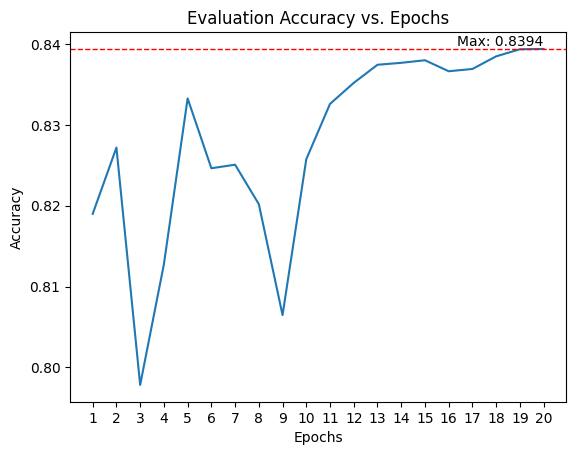

In [16]:
import matplotlib.pyplot as plt

epochs = list(range(1, 21))
acc = [0.819,0.8272,0.79784,0.81276,0.83328,0.82464,0.82508,0.8202,0.80648,0.82576,
       0.8326,0.8352,0.83744,0.83768,0.838,0.83664,0.83692,0.83848,0.83936,0.8394]
###################  Model accuracy is : 0.8394 ###################
plt.plot(epochs, acc)
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Evaluation Accuracy vs. Epochs')

max_acc = max(acc)

plt.axhline(max_acc, color='r', linestyle='--', linewidth=1)
plt.text(epochs[-1], max_acc, f'Max: {max_acc}', ha='right', va='bottom')
filename = "q5a_eval_acc_plot.png"
plt.savefig(filename)
plt.show()

**Section B**

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.6251, 'learning_rate': 0.000992, 'epoch': 0.16}
{'loss': 0.5066, 'learning_rate': 0.000984, 'epoch': 0.32}
{'loss': 0.4518, 'learning_rate': 0.000976, 'epoch': 0.48}
{'loss': 0.4323, 'learning_rate': 0.000968, 'epoch': 0.64}
{'loss': 0.4514, 'learning_rate': 0.00096, 'epoch': 0.8}
{'loss': 0.4308, 'learning_rate': 0.0009519999999999999, 'epoch': 0.96}
{'eval_loss': 0.4273533523082733, 'eval_accuracy': 0.816, 'eval_runtime': 12.4207, 'eval_samples_per_second': 2012.769, 'eval_steps_per_second': 251.596, 'epoch': 1.0}
{'loss': 0.4264, 'learning_rate': 0.000944, 'epoch': 1.12}
{'loss': 0.4268, 'learning_rate': 0.0009360000000000001, 'epoch': 1.28}
{'loss': 0.3985, 'learning_rate': 0.0009280000000000001, 'epoch': 1.44}
{'loss': 0.414, 'learning_rate': 0.00092, 'epoch': 1.6}
{'loss': 0.4121, 'learning_rate': 0.000912, 'epoch': 1.76}
{'loss': 0.4049, 'learning_rate': 0.0009040000000000001, 'epoch': 1.92}
{'eval_loss': 0.4047807455062866, 'eval_accuracy': 0.81784, 'eval_runtime': 1

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.6248, 'learning_rate': 0.000992, 'epoch': 0.16}
{'loss': 0.5079, 'learning_rate': 0.000984, 'epoch': 0.32}
{'loss': 0.4509, 'learning_rate': 0.000976, 'epoch': 0.48}
{'loss': 0.439, 'learning_rate': 0.000968, 'epoch': 0.64}
{'loss': 0.4612, 'learning_rate': 0.00096, 'epoch': 0.8}
{'loss': 0.4337, 'learning_rate': 0.0009519999999999999, 'epoch': 0.96}
{'eval_loss': 0.4478534758090973, 'eval_accuracy': 0.80284, 'eval_runtime': 11.705, 'eval_samples_per_second': 2135.831, 'eval_steps_per_second': 266.979, 'epoch': 1.0}
{'loss': 0.4344, 'learning_rate': 0.000944, 'epoch': 1.12}
{'loss': 0.4352, 'learning_rate': 0.0009360000000000001, 'epoch': 1.28}
{'loss': 0.4029, 'learning_rate': 0.0009280000000000001, 'epoch': 1.44}
{'loss': 0.4167, 'learning_rate': 0.00092, 'epoch': 1.6}
{'loss': 0.419, 'learning_rate': 0.000912, 'epoch': 1.76}
{'loss': 0.4215, 'learning_rate': 0.0009040000000000001, 'epoch': 1.92}
{'eval_loss': 0.39562368392944336, 'eval_accuracy': 0.82324, 'eval_runtime': 

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.6215, 'learning_rate': 0.000992, 'epoch': 0.16}
{'loss': 0.508, 'learning_rate': 0.000984, 'epoch': 0.32}
{'loss': 0.4557, 'learning_rate': 0.000976, 'epoch': 0.48}
{'loss': 0.4354, 'learning_rate': 0.000968, 'epoch': 0.64}
{'loss': 0.4612, 'learning_rate': 0.00096, 'epoch': 0.8}
{'loss': 0.4401, 'learning_rate': 0.0009519999999999999, 'epoch': 0.96}
{'eval_loss': 0.4335074722766876, 'eval_accuracy': 0.80812, 'eval_runtime': 12.4276, 'eval_samples_per_second': 2011.649, 'eval_steps_per_second': 251.456, 'epoch': 1.0}
{'loss': 0.4357, 'learning_rate': 0.000944, 'epoch': 1.12}
{'loss': 0.4471, 'learning_rate': 0.0009360000000000001, 'epoch': 1.28}
{'loss': 0.4091, 'learning_rate': 0.0009280000000000001, 'epoch': 1.44}
{'loss': 0.426, 'learning_rate': 0.00092, 'epoch': 1.6}
{'loss': 0.4231, 'learning_rate': 0.000912, 'epoch': 1.76}
{'loss': 0.4271, 'learning_rate': 0.0009040000000000001, 'epoch': 1.92}
{'eval_loss': 0.39615198969841003, 'eval_accuracy': 0.82036, 'eval_runtime':

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.6272, 'learning_rate': 0.000992, 'epoch': 0.16}
{'loss': 0.5172, 'learning_rate': 0.000984, 'epoch': 0.32}
{'loss': 0.46, 'learning_rate': 0.000976, 'epoch': 0.48}
{'loss': 0.4448, 'learning_rate': 0.000968, 'epoch': 0.64}
{'loss': 0.4664, 'learning_rate': 0.00096, 'epoch': 0.8}
{'loss': 0.4498, 'learning_rate': 0.0009519999999999999, 'epoch': 0.96}
{'eval_loss': 0.4252527058124542, 'eval_accuracy': 0.80752, 'eval_runtime': 13.5311, 'eval_samples_per_second': 1847.591, 'eval_steps_per_second': 230.949, 'epoch': 1.0}
{'loss': 0.4423, 'learning_rate': 0.000944, 'epoch': 1.12}
{'loss': 0.4521, 'learning_rate': 0.0009360000000000001, 'epoch': 1.28}
{'loss': 0.4163, 'learning_rate': 0.0009280000000000001, 'epoch': 1.44}
{'loss': 0.434, 'learning_rate': 0.00092, 'epoch': 1.6}
{'loss': 0.4276, 'learning_rate': 0.000912, 'epoch': 1.76}
{'loss': 0.4372, 'learning_rate': 0.0009040000000000001, 'epoch': 1.92}
{'eval_loss': 0.39289534091949463, 'eval_accuracy': 0.82564, 'eval_runtime': 

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.6267, 'learning_rate': 0.000992, 'epoch': 0.16}
{'loss': 0.5181, 'learning_rate': 0.000984, 'epoch': 0.32}
{'loss': 0.4682, 'learning_rate': 0.000976, 'epoch': 0.48}
{'loss': 0.45, 'learning_rate': 0.000968, 'epoch': 0.64}
{'loss': 0.4736, 'learning_rate': 0.00096, 'epoch': 0.8}
{'loss': 0.4582, 'learning_rate': 0.0009519999999999999, 'epoch': 0.96}
{'eval_loss': 0.4326270818710327, 'eval_accuracy': 0.80008, 'eval_runtime': 12.779, 'eval_samples_per_second': 1956.339, 'eval_steps_per_second': 244.542, 'epoch': 1.0}
{'loss': 0.4521, 'learning_rate': 0.000944, 'epoch': 1.12}
{'loss': 0.4623, 'learning_rate': 0.0009360000000000001, 'epoch': 1.28}
{'loss': 0.4292, 'learning_rate': 0.0009280000000000001, 'epoch': 1.44}
{'loss': 0.4424, 'learning_rate': 0.00092, 'epoch': 1.6}
{'loss': 0.435, 'learning_rate': 0.000912, 'epoch': 1.76}
{'loss': 0.4461, 'learning_rate': 0.0009040000000000001, 'epoch': 1.92}
{'eval_loss': 0.3946523368358612, 'eval_accuracy': 0.82424, 'eval_runtime': 12

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.6281, 'learning_rate': 0.000992, 'epoch': 0.16}
{'loss': 0.5276, 'learning_rate': 0.000984, 'epoch': 0.32}
{'loss': 0.4767, 'learning_rate': 0.000976, 'epoch': 0.48}
{'loss': 0.4585, 'learning_rate': 0.000968, 'epoch': 0.64}
{'loss': 0.482, 'learning_rate': 0.00096, 'epoch': 0.8}
{'loss': 0.4644, 'learning_rate': 0.0009519999999999999, 'epoch': 0.96}
{'eval_loss': 0.41095027327537537, 'eval_accuracy': 0.81788, 'eval_runtime': 12.4077, 'eval_samples_per_second': 2014.882, 'eval_steps_per_second': 251.86, 'epoch': 1.0}
{'loss': 0.4622, 'learning_rate': 0.000944, 'epoch': 1.12}
{'loss': 0.4745, 'learning_rate': 0.0009360000000000001, 'epoch': 1.28}
{'loss': 0.4394, 'learning_rate': 0.0009280000000000001, 'epoch': 1.44}
{'loss': 0.4552, 'learning_rate': 0.00092, 'epoch': 1.6}
{'loss': 0.4499, 'learning_rate': 0.000912, 'epoch': 1.76}
{'loss': 0.4574, 'learning_rate': 0.0009040000000000001, 'epoch': 1.92}
{'eval_loss': 0.40417471528053284, 'eval_accuracy': 0.81836, 'eval_runtime'

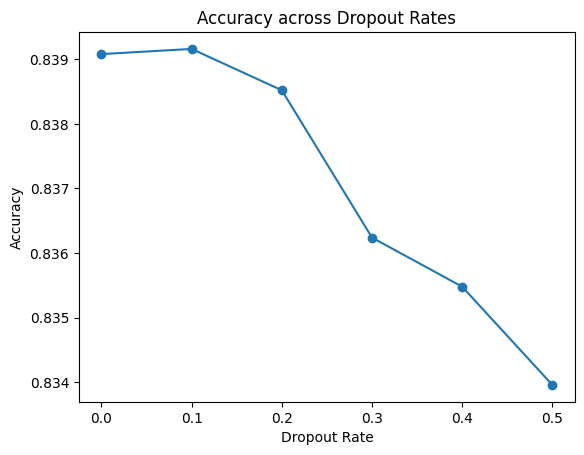

In [ ]:
from torch import nn
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import Trainer
from transformers import TrainingArguments
from transformers import DefaultFlowCallback

# Use nn.Sequential and nn.Linear for the network, and nn.CrossEntropyLoss for the loss.
# Make sure that the final layer has output dimension of size 2.
class DAN(nn.Module):
    def __init__(self, dropout_rate):
        super().__init__()
        self.num_labels = 2
        self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))
        # YOUR CODE HERE
        self.embedding_dim = np.load("glove.npy").shape[1]
        self.hidden_layer = nn.Linear(self.embedding_dim, self.embedding_dim // 2)
        self.activation = nn.ReLU()
        self.hidden_layer2 = nn.Linear(self.embedding_dim // 2, (self.embedding_dim // 4))
        self.output_layer = nn.Linear(self.embedding_dim // 4, self.num_labels)
        self.classifier = nn.Sequential(
            self.hidden_layer,
            self.activation,
            self.hidden_layer2,
            self.activation,
            self.output_layer
        )
        self.loss = nn.CrossEntropyLoss()
        self.dropout_rate = dropout_rate
        # END YOUR END

    def dropout(self, input_tensor, attention_masks):
        if self.training:
            dropout = torch.ones_like(input_tensor)
            dropout_mask = dropout.bernoulli_(1 - self.dropout_rate) * attention_masks.unsqueeze(-1)
            dropout_tensor = dropout_mask / (1 - self.dropout_rate) * input_tensor
        else:
            dropout_tensor = input_tensor
        return dropout_tensor

    def forward(self, input_ids, attention_masks, labels=None, **kwargs):
        # YOUR CODE HERE
        embedded_input = self.embeddings(input_ids)
        embedded_input = self.dropout(embedded_input, attention_masks)
        avg = embedded_input.mean(dim=1)
        hidden_output = self.classifier(avg)
        # END YOUR END
        res = self.classifier(avg)
        loss = self.loss(res, labels)
        return {"loss": loss, "logits": res}

dropout_rates = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]  
#dropout_rates = [0.4] 
# Tested each value from the array each time for time convenience.
accuracy_values = []  

for dropout_rate in dropout_rates:
    co = DataCollatorWithPadding()
    training_args = TrainingArguments(
        "DAN",
        # YOUR CODE HERE
        num_train_epochs=20,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        learning_rate=0.001,
        # END YOUR END
        
        save_total_limit=2,
        log_level="error",
        evaluation_strategy="epoch"
    )
    model = DAN(dropout_rate)
    trainer = Trainer(
        model=model,
        data_collator=co,
        args=training_args,
        train_dataset=small_train_dataset,
        eval_dataset=small_eval_dataset,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    result = trainer.evaluate(small_eval_dataset)
    accuracy = result["eval_accuracy"]
    accuracy_values.append(accuracy)


plt.plot(dropout_rates, accuracy_values, marker='o')
plt.xlabel("Dropout Rate")
plt.ylabel("Accuracy")
plt.title("Accuracy across Dropout Rates")
plt.show()

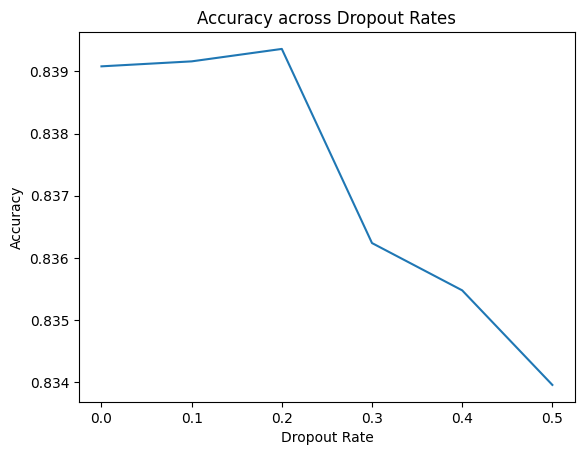

In [ ]:
import matplotlib.pyplot as plt

dropout_rate = [0,0.1,0.2,0.3,0.4,0.5]
acc = [0.83908,0.83916,0.83936,0.83624,0.83548,0.83396]
max_acc = max(acc)

#plt.axhline(max_acc, color='r', linestyle='--', linewidth=1)
#plt.text(dropout_rate[-1], max_acc, f'Max: {max_acc}', ha='right', va='bottom')

plt.plot(dropout_rate, acc)
plt.xticks(dropout_rate)

plt.xlabel('Dropout Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy across Dropout Rates')

filename = "q5b_dropout_rate1_acc_plot.png"
plt.savefig(filename)
plt.show()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.6252, 'learning_rate': 0.000992, 'epoch': 0.16}
{'loss': 0.5079, 'learning_rate': 0.000984, 'epoch': 0.32}
{'loss': 0.4533, 'learning_rate': 0.000976, 'epoch': 0.48}
{'loss': 0.4316, 'learning_rate': 0.000968, 'epoch': 0.64}
{'loss': 0.4545, 'learning_rate': 0.00096, 'epoch': 0.8}
{'loss': 0.4287, 'learning_rate': 0.0009519999999999999, 'epoch': 0.96}
{'eval_loss': 0.4146071970462799, 'eval_accuracy': 0.82116, 'eval_runtime': 12.4909, 'eval_samples_per_second': 2001.465, 'eval_steps_per_second': 250.183, 'epoch': 1.0}
{'loss': 0.4257, 'learning_rate': 0.000944, 'epoch': 1.12}
{'loss': 0.4276, 'learning_rate': 0.0009360000000000001, 'epoch': 1.28}
{'loss': 0.397, 'learning_rate': 0.0009280000000000001, 'epoch': 1.44}
{'loss': 0.4115, 'learning_rate': 0.00092, 'epoch': 1.6}
{'loss': 0.4138, 'learning_rate': 0.000912, 'epoch': 1.76}
{'loss': 0.4061, 'learning_rate': 0.0009040000000000001, 'epoch': 1.92}
{'eval_loss': 0.39431777596473694, 'eval_accuracy': 0.82628, 'eval_runtime'

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.6253, 'learning_rate': 0.000992, 'epoch': 0.16}
{'loss': 0.51, 'learning_rate': 0.000984, 'epoch': 0.32}
{'loss': 0.4617, 'learning_rate': 0.000976, 'epoch': 0.48}
{'loss': 0.4353, 'learning_rate': 0.000968, 'epoch': 0.64}
{'loss': 0.4546, 'learning_rate': 0.00096, 'epoch': 0.8}
{'loss': 0.432, 'learning_rate': 0.0009519999999999999, 'epoch': 0.96}
{'eval_loss': 0.41354596614837646, 'eval_accuracy': 0.81996, 'eval_runtime': 12.5853, 'eval_samples_per_second': 1986.44, 'eval_steps_per_second': 248.305, 'epoch': 1.0}
{'loss': 0.4304, 'learning_rate': 0.000944, 'epoch': 1.12}
{'loss': 0.4385, 'learning_rate': 0.0009360000000000001, 'epoch': 1.28}
{'loss': 0.4083, 'learning_rate': 0.0009280000000000001, 'epoch': 1.44}
{'loss': 0.4199, 'learning_rate': 0.00092, 'epoch': 1.6}
{'loss': 0.4225, 'learning_rate': 0.000912, 'epoch': 1.76}
{'loss': 0.4221, 'learning_rate': 0.0009040000000000001, 'epoch': 1.92}
{'eval_loss': 0.4386894106864929, 'eval_accuracy': 0.795, 'eval_runtime': 12.

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.6316, 'learning_rate': 0.000992, 'epoch': 0.16}
{'loss': 0.5157, 'learning_rate': 0.000984, 'epoch': 0.32}
{'loss': 0.4721, 'learning_rate': 0.000976, 'epoch': 0.48}
{'loss': 0.4482, 'learning_rate': 0.000968, 'epoch': 0.64}
{'loss': 0.4672, 'learning_rate': 0.00096, 'epoch': 0.8}
{'loss': 0.4411, 'learning_rate': 0.0009519999999999999, 'epoch': 0.96}
{'eval_loss': 0.4098030924797058, 'eval_accuracy': 0.8206, 'eval_runtime': 11.4801, 'eval_samples_per_second': 2177.69, 'eval_steps_per_second': 272.211, 'epoch': 1.0}
{'loss': 0.4394, 'learning_rate': 0.000944, 'epoch': 1.12}
{'loss': 0.4409, 'learning_rate': 0.0009360000000000001, 'epoch': 1.28}
{'loss': 0.415, 'learning_rate': 0.0009280000000000001, 'epoch': 1.44}
{'loss': 0.4251, 'learning_rate': 0.00092, 'epoch': 1.6}
{'loss': 0.4324, 'learning_rate': 0.000912, 'epoch': 1.76}
{'loss': 0.4288, 'learning_rate': 0.0009040000000000001, 'epoch': 1.92}
{'eval_loss': 0.41743144392967224, 'eval_accuracy': 0.80372, 'eval_runtime': 

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.6285, 'learning_rate': 0.000992, 'epoch': 0.16}
{'loss': 0.5172, 'learning_rate': 0.000984, 'epoch': 0.32}
{'loss': 0.4809, 'learning_rate': 0.000976, 'epoch': 0.48}
{'loss': 0.4556, 'learning_rate': 0.000968, 'epoch': 0.64}
{'loss': 0.4827, 'learning_rate': 0.00096, 'epoch': 0.8}
{'loss': 0.4543, 'learning_rate': 0.0009519999999999999, 'epoch': 0.96}
{'eval_loss': 0.4229928255081177, 'eval_accuracy': 0.81064, 'eval_runtime': 11.9562, 'eval_samples_per_second': 2090.962, 'eval_steps_per_second': 261.37, 'epoch': 1.0}
{'loss': 0.4495, 'learning_rate': 0.000944, 'epoch': 1.12}
{'loss': 0.4515, 'learning_rate': 0.0009360000000000001, 'epoch': 1.28}
{'loss': 0.425, 'learning_rate': 0.0009280000000000001, 'epoch': 1.44}
{'loss': 0.4352, 'learning_rate': 0.00092, 'epoch': 1.6}
{'loss': 0.4485, 'learning_rate': 0.000912, 'epoch': 1.76}
{'loss': 0.445, 'learning_rate': 0.0009040000000000001, 'epoch': 1.92}
{'eval_loss': 0.4842756688594818, 'eval_accuracy': 0.76312, 'eval_runtime': 1

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.6298, 'learning_rate': 0.000992, 'epoch': 0.16}
{'loss': 0.5271, 'learning_rate': 0.000984, 'epoch': 0.32}
{'loss': 0.4882, 'learning_rate': 0.000976, 'epoch': 0.48}
{'loss': 0.4685, 'learning_rate': 0.000968, 'epoch': 0.64}
{'loss': 0.4977, 'learning_rate': 0.00096, 'epoch': 0.8}
{'loss': 0.4679, 'learning_rate': 0.0009519999999999999, 'epoch': 0.96}
{'eval_loss': 0.42321258783340454, 'eval_accuracy': 0.80932, 'eval_runtime': 12.2764, 'eval_samples_per_second': 2036.433, 'eval_steps_per_second': 254.554, 'epoch': 1.0}
{'loss': 0.464, 'learning_rate': 0.000944, 'epoch': 1.12}
{'loss': 0.4605, 'learning_rate': 0.0009360000000000001, 'epoch': 1.28}
{'loss': 0.4418, 'learning_rate': 0.0009280000000000001, 'epoch': 1.44}
{'loss': 0.4482, 'learning_rate': 0.00092, 'epoch': 1.6}
{'loss': 0.4656, 'learning_rate': 0.000912, 'epoch': 1.76}
{'loss': 0.4616, 'learning_rate': 0.0009040000000000001, 'epoch': 1.92}
{'eval_loss': 0.4493910074234009, 'eval_accuracy': 0.78428, 'eval_runtime'

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.6339, 'learning_rate': 0.000992, 'epoch': 0.16}
{'loss': 0.543, 'learning_rate': 0.000984, 'epoch': 0.32}
{'loss': 0.5003, 'learning_rate': 0.000976, 'epoch': 0.48}
{'loss': 0.4875, 'learning_rate': 0.000968, 'epoch': 0.64}
{'loss': 0.5113, 'learning_rate': 0.00096, 'epoch': 0.8}
{'loss': 0.4845, 'learning_rate': 0.0009519999999999999, 'epoch': 0.96}
{'eval_loss': 0.46338558197021484, 'eval_accuracy': 0.77816, 'eval_runtime': 12.0776, 'eval_samples_per_second': 2069.942, 'eval_steps_per_second': 258.743, 'epoch': 1.0}
{'loss': 0.4774, 'learning_rate': 0.000944, 'epoch': 1.12}
{'loss': 0.4801, 'learning_rate': 0.0009360000000000001, 'epoch': 1.28}
{'loss': 0.4559, 'learning_rate': 0.0009280000000000001, 'epoch': 1.44}
{'loss': 0.4611, 'learning_rate': 0.00092, 'epoch': 1.6}
{'loss': 0.4833, 'learning_rate': 0.000912, 'epoch': 1.76}
{'loss': 0.4737, 'learning_rate': 0.0009040000000000001, 'epoch': 1.92}
{'eval_loss': 0.4212334454059601, 'eval_accuracy': 0.80792, 'eval_runtime'

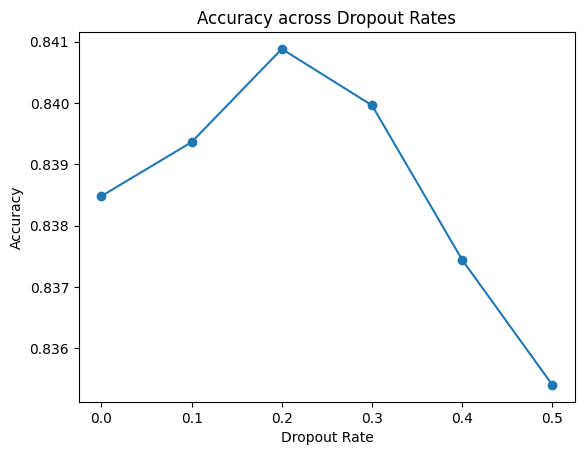

In [ ]:
from torch import nn
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import Trainer
from transformers import TrainingArguments
from transformers import DefaultFlowCallback

# Use nn.Sequential and nn.Linear for the network, and nn.CrossEntropyLoss for the loss.
# Make sure that the final layer has output dimension of size 2.
class DAN(nn.Module):
    def __init__(self, dropout_rate):
        super().__init__()
        self.num_labels = 2
        self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))
        # YOUR CODE HERE
        self.embedding_dim = np.load("glove.npy").shape[1]
        self.hidden_layer = nn.Linear(self.embedding_dim, self.embedding_dim // 2)
        self.activation = nn.ReLU()
        self.hidden_layer2 = nn.Linear(self.embedding_dim // 2, (self.embedding_dim // 4))
        self.output_layer = nn.Linear(self.embedding_dim // 4, self.num_labels)
        self.classifier = nn.Sequential(
            self.hidden_layer,
            self.activation,
            self.hidden_layer2,
            self.activation,
            self.output_layer
        )
        self.loss = nn.CrossEntropyLoss()
        self.dropout_input = nn.Dropout1d(dropout_rate)
        # END YOUR END

    def forward(self, input_ids, attention_masks, labels=None, **kwargs):
        # YOUR CODE HERE      
        embedded_input = self.embeddings(input_ids)
        embedded_input = self.dropout_input(embedded_input)
        avg = embedded_input.mean(dim=1)
        hidden_output = self.classifier(avg)
        # END YOUR END
        res = self.classifier(avg)
        loss = self.loss(res, labels)
        return {"loss": loss, "logits": res}


dropout_rates = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5] 
# Tested each value from the array each time for time convenience.
accuracy_values = [] 

for dropout_rate in dropout_rates:
    co = DataCollatorWithPadding()
    training_args = TrainingArguments(
        "DAN",
        # YOUR CODE HERE
        num_train_epochs=20,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        learning_rate=0.001,
        # END YOUR END
        
        save_total_limit=2,
        log_level="error",
        evaluation_strategy="epoch"
    )
    model = DAN(dropout_rate)
    trainer = Trainer(
        model=model,
        data_collator=co,
        args=training_args,
        train_dataset=small_train_dataset,
        eval_dataset=small_eval_dataset,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    result = trainer.evaluate(small_eval_dataset)
    accuracy = result["eval_accuracy"]
    accuracy_values.append(accuracy)

plt.plot(dropout_rates, accuracy_values, marker='o')
plt.xlabel("Dropout Rate")
plt.ylabel("Accuracy")
plt.title("Accuracy across Dropout Rates")
plt.show()

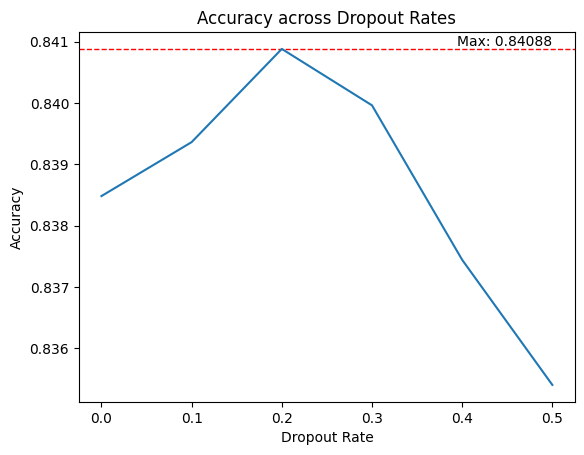

In [ ]:
import matplotlib.pyplot as plt

dropout_rate = [0,0.1,0.2,0.3,0.4,0.5]
acc = [0.83848,0.83936,0.84088,0.83996,0.83744,0.8354]
max_acc = max(acc)

plt.axhline(max_acc, color='r', linestyle='--', linewidth=1)
plt.text(dropout_rate[-1], max_acc, f'Max: {max_acc}', ha='right', va='bottom')
plt.plot(dropout_rate, acc)
plt.xticks(dropout_rate)

plt.xlabel('Dropout Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy across Dropout Rates')

filename = "q5b_dropout_rate1_acc_plot.png"
plt.savefig(filename)
plt.show()


**Section C**

**0 Hidden Layers**

In [ ]:
from torch import nn
import torch


#Use nn.Sequential and nn.Linear for the network, and nn.CrossEntropyLoss for the loss.
#Make sure that the final layer has output dimension of size 2.
class DAN(nn.Module):
  def __init__(self):
          super().__init__()
          self.num_labels = 2
          self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))
          self.embedding_dim = np.load("glove.npy").shape[1]
          # ----------------------------------------------
          # YOUR CODE HERE
          self.activation = nn.ReLU()
          self.output_layer = nn.Linear(self.embedding_dim, self.num_labels)
          self.classifier = nn.Sequential(
              self.output_layer
          )
          self.loss = nn.CrossEntropyLoss()
          # END YOUR END
          # ----------------------------------------------


  def forward(self,input_ids,attention_masks,labels=None,**kwargs):
      # YOUR CODE HERE
      # ----------------------------------------------
      embedded_input = self.embeddings(input_ids)
      avg = embedded_input.mean(dim=1)
      hidden_output = self.classifier(avg)
      # END YOUR END
      # ----------------------------------------------
      res = self.classifier(avg)
      loss = self.loss(res,labels)
      return {"loss":loss,"logits":res}

In [ ]:
#Hint: You may want to look at https://huggingface.co/transformers/main_classes/callback.html
from transformers import Trainer
from transformers import TrainingArguments

co = DataCollatorWithPadding()
training_args = TrainingArguments("DAN",
                                  # YOUR CODE HERE
                                  num_train_epochs=20,
                                  per_device_train_batch_size=8,
                                  per_device_eval_batch_size=8,
                                  learning_rate=0.001,
                                  # END YOUR END
                                  
                                  save_total_limit=2,
                                  log_level="error",
                                  evaluation_strategy="epoch")
model = DAN()

    

trainer = Trainer(
    model=model,
    data_collator=co,
    args=training_args,
    callbacks = [
                 # YOUR CODE HERE

                 # END YOUR END
    ],
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.6732, 'learning_rate': 0.000992, 'epoch': 0.16}
{'loss': 0.6492, 'learning_rate': 0.000984, 'epoch': 0.32}
{'loss': 0.631, 'learning_rate': 0.000976, 'epoch': 0.48}
{'loss': 0.6241, 'learning_rate': 0.000968, 'epoch': 0.64}
{'loss': 0.6166, 'learning_rate': 0.00096, 'epoch': 0.8}
{'loss': 0.6086, 'learning_rate': 0.0009519999999999999, 'epoch': 0.96}
{'eval_loss': 0.6021037697792053, 'eval_accuracy': 0.71608, 'eval_runtime': 12.1824, 'eval_samples_per_second': 2052.144, 'eval_steps_per_second': 256.518, 'epoch': 1.0}
{'loss': 0.5965, 'learning_rate': 0.000944, 'epoch': 1.12}
{'loss': 0.5861, 'learning_rate': 0.0009360000000000001, 'epoch': 1.28}
{'loss': 0.5755, 'learning_rate': 0.0009280000000000001, 'epoch': 1.44}
{'loss': 0.5802, 'learning_rate': 0.00092, 'epoch': 1.6}
{'loss': 0.5784, 'learning_rate': 0.000912, 'epoch': 1.76}
{'loss': 0.5651, 'learning_rate': 0.0009040000000000001, 'epoch': 1.92}
{'eval_loss': 0.5670952200889587, 'eval_accuracy': 0.75212, 'eval_runtime':

TrainOutput(global_step=62500, training_loss=0.49764433349609377, metrics={'train_runtime': 966.4324, 'train_samples_per_second': 517.367, 'train_steps_per_second': 64.671, 'train_loss': 0.49764433349609377, 'epoch': 20.0})

**1 Hidden Layer**

In [ ]:
from torch import nn
import torch


#Use nn.Sequential and nn.Linear for the network, and nn.CrossEntropyLoss for the loss.
#Make sure that the final layer has output dimension of size 2.
class DAN(nn.Module):
  def __init__(self):
          super().__init__()
          self.num_labels = 2
          self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))
          self.embedding_dim = np.load("glove.npy").shape[1]
          # ----------------------------------------------
          # YOUR CODE HERE
          self.hidden_layer = nn.Linear(self.embedding_dim, self.embedding_dim // 2)
          self.activation = nn.ReLU()
          self.output_layer = nn.Linear(self.embedding_dim // 2, self.num_labels)
          self.classifier = nn.Sequential(
              self.hidden_layer,
              self.activation,
              self.output_layer
          )
          self.loss = nn.CrossEntropyLoss()
          # END YOUR END
          # ----------------------------------------------


  def forward(self,input_ids,attention_masks,labels=None,**kwargs):
      # YOUR CODE HERE
      # ----------------------------------------------
      embedded_input = self.embeddings(input_ids)
      avg = embedded_input.mean(dim=1)
      hidden_output = self.classifier(avg)
      # END YOUR END
      # ----------------------------------------------
      res = self.classifier(avg)
      loss = self.loss(res,labels)
      return {"loss":loss,"logits":res}

In [ ]:
#Hint: You may want to look at https://huggingface.co/transformers/main_classes/callback.html
from transformers import Trainer
from transformers import TrainingArguments

co = DataCollatorWithPadding()
training_args = TrainingArguments("DAN",
                                  # YOUR CODE HERE
                                  num_train_epochs=20,
                                  per_device_train_batch_size=8,
                                  per_device_eval_batch_size=8,
                                  learning_rate=0.001,
                                  # END YOUR END
                                  
                                  save_total_limit=2,
                                  log_level="error",
                                  evaluation_strategy="epoch")
model = DAN()

    

trainer = Trainer(
    model=model,
    data_collator=co,
    args=training_args,
    callbacks = [
                 # YOUR CODE HERE

                 # END YOUR END
    ],
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.6382, 'learning_rate': 0.000992, 'epoch': 0.16}
{'loss': 0.5487, 'learning_rate': 0.000984, 'epoch': 0.32}
{'loss': 0.4831, 'learning_rate': 0.000976, 'epoch': 0.48}
{'loss': 0.4611, 'learning_rate': 0.000968, 'epoch': 0.64}
{'loss': 0.4702, 'learning_rate': 0.00096, 'epoch': 0.8}
{'loss': 0.4475, 'learning_rate': 0.0009519999999999999, 'epoch': 0.96}
{'eval_loss': 0.4494907557964325, 'eval_accuracy': 0.80816, 'eval_runtime': 13.7024, 'eval_samples_per_second': 1824.492, 'eval_steps_per_second': 228.062, 'epoch': 1.0}
{'loss': 0.4349, 'learning_rate': 0.000944, 'epoch': 1.12}
{'loss': 0.4379, 'learning_rate': 0.0009360000000000001, 'epoch': 1.28}
{'loss': 0.4045, 'learning_rate': 0.0009280000000000001, 'epoch': 1.44}
{'loss': 0.4263, 'learning_rate': 0.00092, 'epoch': 1.6}
{'loss': 0.4157, 'learning_rate': 0.000912, 'epoch': 1.76}
{'loss': 0.4211, 'learning_rate': 0.0009040000000000001, 'epoch': 1.92}
{'eval_loss': 0.4139505922794342, 'eval_accuracy': 0.82, 'eval_runtime': 1

TrainOutput(global_step=62500, training_loss=0.3834979113769531, metrics={'train_runtime': 1008.1141, 'train_samples_per_second': 495.976, 'train_steps_per_second': 61.997, 'train_loss': 0.3834979113769531, 'epoch': 20.0})

**2 Hidden Layers**

In [ ]:
from torch import nn
import torch


#Use nn.Sequential and nn.Linear for the network, and nn.CrossEntropyLoss for the loss.
#Make sure that the final layer has output dimension of size 2.
class DAN(nn.Module):
  def __init__(self):
          super().__init__()
          self.num_labels = 2
          self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))
          self.embedding_dim = np.load("glove.npy").shape[1]
          # ----------------------------------------------
          # YOUR CODE HERE
          self.hidden_layer = nn.Linear(self.embedding_dim, self.embedding_dim // 2)
          self.hidden_layer2 = nn.Linear(self.embedding_dim // 2, self.embedding_dim // 4)
          self.activation = nn.ReLU()
          self.output_layer = nn.Linear(self.embedding_dim // 4, self.num_labels)
          self.classifier = nn.Sequential(
              self.hidden_layer,
              self.activation,
              self.hidden_layer2,
              self.activation,
              self.output_layer
          )
          self.loss = nn.CrossEntropyLoss()
          # END YOUR END
          # ----------------------------------------------


  def forward(self,input_ids,attention_masks,labels=None,**kwargs):
      # YOUR CODE HERE
      # ----------------------------------------------
      embedded_input = self.embeddings(input_ids)
      avg = embedded_input.mean(dim=1)
      hidden_output = self.classifier(avg)
      # END YOUR END
      # ----------------------------------------------
      res = self.classifier(avg)
      loss = self.loss(res,labels)
      return {"loss":loss,"logits":res}

In [ ]:
#Hint: You may want to look at https://huggingface.co/transformers/main_classes/callback.html
from transformers import Trainer
from transformers import TrainingArguments

co = DataCollatorWithPadding()
training_args = TrainingArguments("DAN",
                                  # YOUR CODE HERE
                                  num_train_epochs=20,
                                  per_device_train_batch_size=8,
                                  per_device_eval_batch_size=8,
                                  learning_rate=0.001,
                                  # END YOUR END
                                  
                                  save_total_limit=2,
                                  log_level="error",
                                  evaluation_strategy="epoch")
model = DAN()

    

trainer = Trainer(
    model=model,
    data_collator=co,
    args=training_args,
    callbacks = [
                 # YOUR CODE HERE

                 # END YOUR END
    ],
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.6237, 'learning_rate': 0.000992, 'epoch': 0.16}
{'loss': 0.5032, 'learning_rate': 0.000984, 'epoch': 0.32}
{'loss': 0.4501, 'learning_rate': 0.000976, 'epoch': 0.48}
{'loss': 0.4299, 'learning_rate': 0.000968, 'epoch': 0.64}
{'loss': 0.45, 'learning_rate': 0.00096, 'epoch': 0.8}
{'loss': 0.4304, 'learning_rate': 0.0009519999999999999, 'epoch': 0.96}
{'eval_loss': 0.4181493818759918, 'eval_accuracy': 0.82176, 'eval_runtime': 12.7418, 'eval_samples_per_second': 1962.049, 'eval_steps_per_second': 245.256, 'epoch': 1.0}
{'loss': 0.4245, 'learning_rate': 0.000944, 'epoch': 1.12}
{'loss': 0.4275, 'learning_rate': 0.0009360000000000001, 'epoch': 1.28}
{'loss': 0.3965, 'learning_rate': 0.0009280000000000001, 'epoch': 1.44}
{'loss': 0.4143, 'learning_rate': 0.00092, 'epoch': 1.6}
{'loss': 0.414, 'learning_rate': 0.000912, 'epoch': 1.76}
{'loss': 0.4084, 'learning_rate': 0.0009040000000000001, 'epoch': 1.92}
{'eval_loss': 0.3875053822994232, 'eval_accuracy': 0.83068, 'eval_runtime': 1

TrainOutput(global_step=62500, training_loss=0.379512302734375, metrics={'train_runtime': 984.3427, 'train_samples_per_second': 507.953, 'train_steps_per_second': 63.494, 'train_loss': 0.379512302734375, 'epoch': 20.0})

**3 Hidden Layers**

In [ ]:
from torch import nn
import torch


#Use nn.Sequential and nn.Linear for the network, and nn.CrossEntropyLoss for the loss.
#Make sure that the final layer has output dimension of size 2.
class DAN(nn.Module):
  def __init__(self):
          super().__init__()
          self.num_labels = 2
          self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))
          self.embedding_dim = np.load("glove.npy").shape[1]
          # ----------------------------------------------
          # YOUR CODE HERE
          self.hidden_layer = nn.Linear(self.embedding_dim, self.embedding_dim // 2)
          self.hidden_layer2 = nn.Linear(self.embedding_dim // 2, self.embedding_dim // 4)
          self.hidden_layer3 = nn.Linear(self.embedding_dim // 4, self.embedding_dim // 8)
          self.activation = nn.ReLU()
          self.output_layer = nn.Linear(self.embedding_dim // 8, self.num_labels)
          self.classifier = nn.Sequential(
              self.hidden_layer,
              self.activation,
              self.hidden_layer2,
              self.activation,
              self.hidden_layer3,
              self.activation,
              self.output_layer
          )
          self.loss = nn.CrossEntropyLoss()
          # END YOUR END
          # ----------------------------------------------


  def forward(self,input_ids,attention_masks,labels=None,**kwargs):
      # YOUR CODE HERE
      # ----------------------------------------------
      embedded_input = self.embeddings(input_ids)
      avg = embedded_input.mean(dim=1)
      hidden_output = self.classifier(avg)
      # END YOUR END
      # ----------------------------------------------
      res = self.classifier(avg)
      loss = self.loss(res,labels)
      return {"loss":loss,"logits":res}

In [ ]:
#Hint: You may want to look at https://huggingface.co/transformers/main_classes/callback.html
from transformers import Trainer
from transformers import TrainingArguments

co = DataCollatorWithPadding()
training_args = TrainingArguments("DAN",
                                  # YOUR CODE HERE
                                  num_train_epochs=20,
                                  per_device_train_batch_size=8,
                                  per_device_eval_batch_size=8,
                                  learning_rate=0.001,
                                  # END YOUR END
                                  
                                  save_total_limit=2,
                                  log_level="error",
                                  evaluation_strategy="epoch")
model = DAN()

    

trainer = Trainer(
    model=model,
    data_collator=co,
    args=training_args,
    callbacks = [
                 # YOUR CODE HERE

                 # END YOUR END
    ],
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.6273, 'learning_rate': 0.000992, 'epoch': 0.16}
{'loss': 0.5011, 'learning_rate': 0.000984, 'epoch': 0.32}
{'loss': 0.4518, 'learning_rate': 0.000976, 'epoch': 0.48}
{'loss': 0.4247, 'learning_rate': 0.000968, 'epoch': 0.64}
{'loss': 0.4567, 'learning_rate': 0.00096, 'epoch': 0.8}
{'loss': 0.4248, 'learning_rate': 0.0009519999999999999, 'epoch': 0.96}
{'eval_loss': 0.4154733121395111, 'eval_accuracy': 0.81912, 'eval_runtime': 13.1118, 'eval_samples_per_second': 1906.679, 'eval_steps_per_second': 238.335, 'epoch': 1.0}
{'loss': 0.4238, 'learning_rate': 0.000944, 'epoch': 1.12}
{'loss': 0.4295, 'learning_rate': 0.0009360000000000001, 'epoch': 1.28}
{'loss': 0.4008, 'learning_rate': 0.0009280000000000001, 'epoch': 1.44}
{'loss': 0.4162, 'learning_rate': 0.00092, 'epoch': 1.6}
{'loss': 0.4138, 'learning_rate': 0.000912, 'epoch': 1.76}
{'loss': 0.4082, 'learning_rate': 0.0009040000000000001, 'epoch': 1.92}
{'eval_loss': 0.3868921995162964, 'eval_accuracy': 0.82828, 'eval_runtime'

TrainOutput(global_step=62500, training_loss=0.38117797705078127, metrics={'train_runtime': 979.5557, 'train_samples_per_second': 510.435, 'train_steps_per_second': 63.804, 'train_loss': 0.38117797705078127, 'epoch': 20.0})

**4 Hidden Layers**

In [21]:
from torch import nn
import torch


#Use nn.Sequential and nn.Linear for the network, and nn.CrossEntropyLoss for the loss.
#Make sure that the final layer has output dimension of size 2.
class DAN(nn.Module):
  def __init__(self):
          super().__init__()
          self.num_labels = 2
          self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))
          self.embedding_dim = np.load("glove.npy").shape[1]
          # ----------------------------------------------
          # YOUR CODE HERE
          self.hidden_layer = nn.Linear(self.embedding_dim, self.embedding_dim // 2)
          self.hidden_layer2 = nn.Linear(self.embedding_dim // 2, self.embedding_dim // 4)
          self.hidden_layer3 = nn.Linear(self.embedding_dim // 4, self.embedding_dim // 8)
          self.hidden_layer4 = nn.Linear(self.embedding_dim // 8, self.embedding_dim // 16)
          self.activation = nn.ReLU()
          self.output_layer = nn.Linear(self.embedding_dim // 16, self.num_labels)
          self.classifier = nn.Sequential(
              self.hidden_layer,
              self.activation,
              self.hidden_layer2,
              self.activation,
              self.hidden_layer3,
              self.activation,
              self.hidden_layer4,
              self.activation,
              self.output_layer
          )
          self.loss = nn.CrossEntropyLoss()
          # END YOUR END
          # ----------------------------------------------


  def forward(self,input_ids,attention_masks,labels=None,**kwargs):
      # YOUR CODE HERE
      # ----------------------------------------------
      embedded_input = self.embeddings(input_ids)
      avg = embedded_input.mean(dim=1)
      hidden_output = self.classifier(avg)
      # END YOUR END
      # ----------------------------------------------
      res = self.classifier(avg)
      loss = self.loss(res,labels)
      return {"loss":loss,"logits":res}



In [22]:
#Hint: You may want to look at https://huggingface.co/transformers/main_classes/callback.html
from transformers import Trainer
from transformers import TrainingArguments

co = DataCollatorWithPadding()
training_args = TrainingArguments("DAN",
                                  # YOUR CODE HERE
                                  num_train_epochs=20,
                                  per_device_train_batch_size=8,
                                  per_device_eval_batch_size=8,
                                  learning_rate=0.001,
                                  # END YOUR END
                                  
                                  save_total_limit=2,
                                  log_level="error",
                                  evaluation_strategy="epoch")
model = DAN()

    

trainer = Trainer(
    model=model,
    data_collator=co,
    args=training_args,
    callbacks = [
                 # YOUR CODE HERE

                 # END YOUR END
    ],
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

In [23]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.6244, 'learning_rate': 0.000992, 'epoch': 0.16}
{'loss': 0.4985, 'learning_rate': 0.000984, 'epoch': 0.32}
{'loss': 0.4469, 'learning_rate': 0.000976, 'epoch': 0.48}
{'loss': 0.4241, 'learning_rate': 0.000968, 'epoch': 0.64}
{'loss': 0.4604, 'learning_rate': 0.00096, 'epoch': 0.8}
{'loss': 0.426, 'learning_rate': 0.0009519999999999999, 'epoch': 0.96}
{'eval_loss': 0.42231059074401855, 'eval_accuracy': 0.81956, 'eval_runtime': 13.2902, 'eval_samples_per_second': 1881.092, 'eval_steps_per_second': 235.137, 'epoch': 1.0}
{'loss': 0.4225, 'learning_rate': 0.000944, 'epoch': 1.12}
{'loss': 0.4289, 'learning_rate': 0.0009360000000000001, 'epoch': 1.28}
{'loss': 0.4059, 'learning_rate': 0.0009280000000000001, 'epoch': 1.44}
{'loss': 0.4186, 'learning_rate': 0.00092, 'epoch': 1.6}
{'loss': 0.4156, 'learning_rate': 0.000912, 'epoch': 1.76}
{'loss': 0.4078, 'learning_rate': 0.0009040000000000001, 'epoch': 1.92}
{'eval_loss': 0.3878965377807617, 'eval_accuracy': 0.82728, 'eval_runtime'

TrainOutput(global_step=62500, training_loss=0.38232816796875, metrics={'train_runtime': 1179.1783, 'train_samples_per_second': 424.024, 'train_steps_per_second': 53.003, 'train_loss': 0.38232816796875, 'epoch': 20.0})

**Plot**

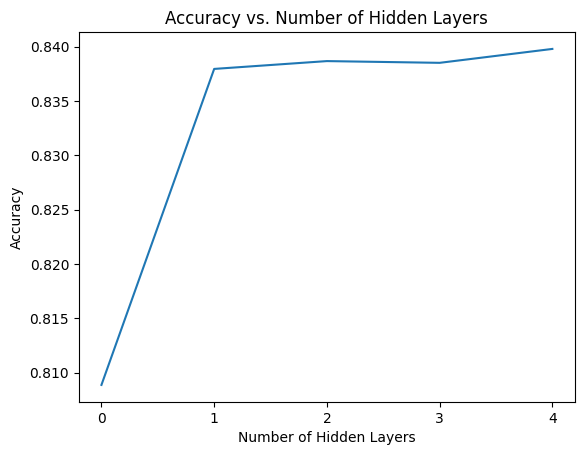

In [ ]:
import matplotlib.pyplot as plt

number_of_hidden_layers = list(range(0, 5))
accuracy = [0.80888, 0.83796, 0.83868, 0.83852, 0.8398]

#plt.axhline(min_acc, color='r', linestyle='--', linewidth=1)
#plt.text(number_of_hidden_layers[-1], min_acc, f'Min: {min_acc}', ha='right', va='bottom')

plt.plot(number_of_hidden_layers, accuracy)
plt.xticks(number_of_hidden_layers)
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Hidden Layers')

filename = "q5c_hidden_layers_acc_plot.png"

plt.savefig(filename)
plt.show()

**Section D**

In [ ]:
from torch import nn
import torch


#Use nn.Sequential and nn.Linear for the network, and nn.CrossEntropyLoss for the loss.
#Make sure that the final layer has output dimension of size 2.
class DAN(nn.Module):
  def __init__(self):
          super().__init__()
          self.num_labels = 2
          self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))
          self.embedding_dim = np.load("glove.npy").shape[1]
          # ----------------------------------------------
          # YOUR CODE HERE
          self.hidden_layer = nn.Linear(self.embedding_dim, self.embedding_dim // 2)
          self.hidden_layer2 = nn.Linear(self.embedding_dim // 2, self.embedding_dim // 4)
          self.hidden_layer3 = nn.Linear(self.embedding_dim // 4, self.embedding_dim // 8)
          self.activation1 = nn.ReLU()
          self.activation2 = nn.Sigmoid()
          self.activation3 = nn.ELU()
          self.output_layer = nn.Linear(self.embedding_dim // 8, self.num_labels)
          self.classifier = nn.Sequential(
              self.hidden_layer,
              self.activation1,
              self.hidden_layer2,
              self.activation2,
              self.hidden_layer3,
              self.activation3,
              self.output_layer
          )
          self.loss = nn.CrossEntropyLoss()
          # END YOUR END
          # ----------------------------------------------


  def forward(self,input_ids,attention_masks,labels=None,**kwargs):
      # YOUR CODE HERE
      # ----------------------------------------------
      embedded_input = self.embeddings(input_ids)
      avg = embedded_input.mean(dim=1)
      hidden_output = self.classifier(avg)
      # END YOUR END
      # ----------------------------------------------
      res = self.classifier(avg)
      loss = self.loss(res,labels)
      return {"loss":loss,"logits":res}

In [ ]:
#Hint: You may want to look at https://huggingface.co/transformers/main_classes/callback.html
from transformers import Trainer
from transformers import TrainingArguments

co = DataCollatorWithPadding()
training_args = TrainingArguments("DAN",
                                  # YOUR CODE HERE
                                  num_train_epochs=20,
                                  per_device_train_batch_size=8,
                                  per_device_eval_batch_size=8,
                                  learning_rate=0.001,
                                  # END YOUR END
                                  
                                  save_total_limit=2,
                                  log_level="error",
                                  evaluation_strategy="epoch")
model = DAN()

    

trainer = Trainer(
    model=model,
    data_collator=co,
    args=training_args,
    callbacks = [
                 # YOUR CODE HERE

                 # END YOUR END
    ],
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.430500,0.424510,0.818320
2,0.406800,0.407214,0.816520
3,0.411800,0.442218,0.797520
4,0.386300,0.424881,0.813880
5,0.385400,0.388617,0.832840
6,0.372400,0.398061,0.823760
7,0.389800,0.385014,0.830520
8,0.375800,0.377850,0.833960
9,0.367700,0.433847,0.811360
10,0.372500,0.400093,0.825400


TrainOutput(global_step=62500, training_loss=0.3789787746582031, metrics={'train_runtime': 995.2223, 'train_samples_per_second': 502.4, 'train_steps_per_second': 62.8, 'total_flos': 0.0, 'train_loss': 0.3789787746582031, 'epoch': 20.0})

**Plot**

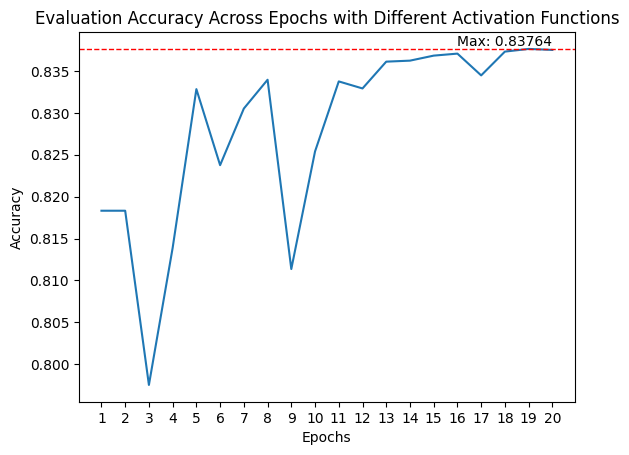

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, 21))
accuracy = [0.818320, 0.818320, 0.797520, 0.813880, 0.832840, 0.823760, 0.830520, 0.833960, 0.811360
, 0.825400, 0.833760, 0.832920, 0.836120
, 0.836240, 0.836840, 0.837080, 0.834480, 0.837320, 0.837640, 0.837520]

plt.plot(epochs, accuracy)
plt.xticks(epochs)
max_acc = max(accuracy)

plt.axhline(max_acc, color='r', linestyle='--', linewidth=1)
plt.text(epochs[-1], max_acc, f'Max: {max_acc}', ha='right', va='bottom')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Evaluation Accuracy Across Epochs with Different Activation Functions')

filename = "q5d_different_activation_functions_plot.png"

plt.savefig(filename)
plt.show()

**Section E**

In [24]:
trainer = Trainer(
      model=model,
      data_collator=co,
      args=training_args,
      callbacks = [
                  # YOUR CODE HERE

                  # END YOUR END
      ],
      train_dataset=small_train_dataset,
      eval_dataset=small_eval_dataset,
      compute_metrics=compute_metrics,
  )
results = trainer.predict(small_eval_dataset)
predicted_labels = np.argmax(results.predictions, axis=-1)
true_labels = results.label_ids
incorrect_indices = np.where(predicted_labels != true_labels)[0][:50]
misclassified_examples = [(small_eval_dataset[int(idx)]['text'], small_eval_dataset[int(idx)]['label']) for idx in incorrect_indices]
sorted_examples = sorted(misclassified_examples, key=lambda x: len(x[0]))

for example in sorted_examples[:5]:
    print("Misclassified example:", example[0])
    print("True label:", example[1])
    print("-----")

Misclassified example: This is, without a doubt, the most hilarious movie I've ever seen. Seriously, if the makers of this movie are ever discovered, they'll put guys like Jim Carrey out of a job. Rent "Jack-O" tonight! Believe me, you won't regret it!
True label: 0
-----
Misclassified example: This is one of the worst Sandra Bullock movie since Speed 2 But not quite that bad. I really lost it with those out of the blue not so "special effect". Guys, If you're an insomniac go with your girl to see this movie. I give it three sleepies!
True label: 0
-----
Misclassified example: I happened to leave HBO on last night following Six Feet Under. What ran next has left me speechless. What an incredible piece of work. I don't just recommend this, I MANDATE that you see this. It's better than anything Hollywood could ever ruin. I just hope they never get their hands on it.
True label: 1
-----
Misclassified example: Great cult flick for MST-3K types: Richard Boone is a mess -- bad hair, arthriti